In [395]:
import sys
import os
sys.path.insert(0, os.path.abspath('../..'))
import torch
import numpy as np
import utils
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
%load_ext autoreload
np.random.seed(2) 
torch.manual_seed(2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [396]:
%autoreload

In [397]:
lcs = utils.get_data('../../datasets/ZTF_g', split=1.0)


validated 3408 files out of 3408 for band='g'
created union_tp attribute of length 3500
dataset created w/ shape (2559, 1, 1974, 3)
train size: 2559, valid size: 0, test size: 0


In [398]:
net, optimizer, args, epoch, loss, train_loss, test_loss = utils.load_checkpoint('../checkpoints/final/ZTF_g0.668415367603302.h5', lcs.data_obj)


=> loading checkpoint '../checkpoints/final/ZTF_g0.668415367603302.h5'
Namespace(n_union_tp=3500, data_folder='datasets/ZTF_g', checkpoint='datasets/ZTF_g0.7037358283996582.h5', start_col=1, inc_errors=False, print_at=1, embed_time=128, enc_num_heads=16, latent_dim=64, mixing='concat', num_ref_points=16, rec_hidden=128, width=512, save_at=30, patience=100, early_stopping=False, niters=20000, frac=0.5, batch_size=2, mse_weight=5.0, dropout=0.0, num_resamples=0, lr=1e-06, scheduler=False, warmup=4000, kl_zero=False, kl_annealing=True, net='hetvae', device='mps', const_var=False, var_per_dim=False, std=0.1, seed=2, save=True, k_iwae=1)


In [399]:
qzs,disc_path = utils.encode(lcs.data_obj['train_loader'], net, device='mps')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1280/1280 [00:18<00:00, 69.34it/s]


In [401]:
num_ref_points = 16 #args.num_ref_points
latent_dim = 64     #args.latent_dim
l = len(lcs.dataset)

n_samples = 10
zs = (np.random.randn(n_samples, qzs.shape[0], qzs.shape[2],qzs.shape[3]) * qzs[:,1,:,:] + qzs[:,0,:,:]).mean(0)

In [402]:
print(zs.shape,disc_path.shape)

(2559, 16, 64) (2559, 16, 64)


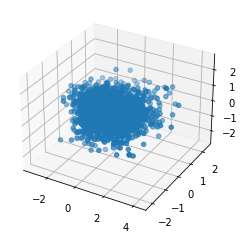

In [403]:
RS = 20150101
pca = PCA(random_state=RS)
pca3d = pca.fit_transform(zs.reshape(zs.shape[0],-1)) 
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(pca3d[:,0],pca3d[:,1],pca3d[:,2])


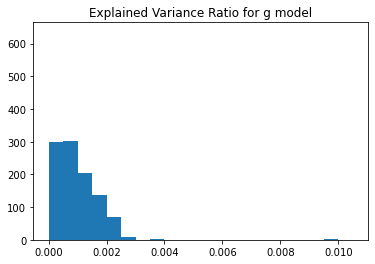

In [404]:
plt.hist(pca.explained_variance_ratio_,bins=np.arange(0.0,0.011,step=0.0005))
plt.ylim(0,665)
plt.title('Explained Variance Ratio for g model')
plt.savefig('../img/pcavar_g')

In [405]:
pca.explained_variance_ratio_[:5] * 100

array([0.99390934, 0.35061214, 0.2929193 , 0.28482585, 0.26889718])

In [366]:
print(abs(pca.components_).shape)

(1024, 1024)


In [418]:
pca3d.shape

(2559, 1024)

In [411]:
(pca.components_[2,:] > 0.05).sum()

39

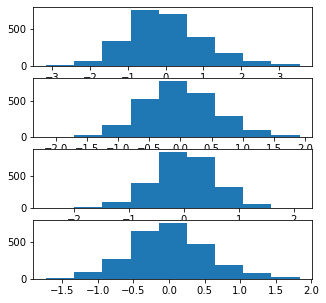

In [412]:
fig, ax = plt.subplots(4, figsize=(5,5))
for i in range(4):
    r1,r2 = np.min(pca3d[:,i]), np.max(pca3d[:,i])
    bins1 = np.arange(r1,r2, step=(r2-r1)/10)
    ax[i].hist(pca3d[:,i],bins=bins1)
    
plt.savefig('../img/pcabins')

In [448]:
bins = 10
interpols = []
for i in range(10): # first 4 pcs
    r1,r2 = np.min(pca3d[:,i]), np.max(pca3d[:,i])
    
    bins1 = np.arange(r1,r2, step=(r2-r1)/10)
    
    bin_i = np.digitize(pca3d[:,i],bins=bins1) # which light curve belongs to which bin? 
    
    # average light curves across bins 
    avgs = [np.concatenate((zs[bin_i==i].mean(0)[np.newaxis],disc_path[bin_i==i].mean(0)[np.newaxis]), axis=0) \
     for i in range(1,bins+1)]
    
    avgs = np.array(avgs,dtype=np.float32)
    
    target_tp = np.arange(0,1500,step=2.5, dtype=np.float32)
    
    target_tp = target_tp[np.newaxis].repeat(len(lcs.bands),axis=0)[np.newaxis].repeat(len(bins1),axis=0)
    
    interps = utils.decode(net,zs=avgs[:,0],disc_path=avgs[:,1],target_x=target_tp,device='mps', batch_size=2)
    
    interpols.append(interps)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.73it/s]


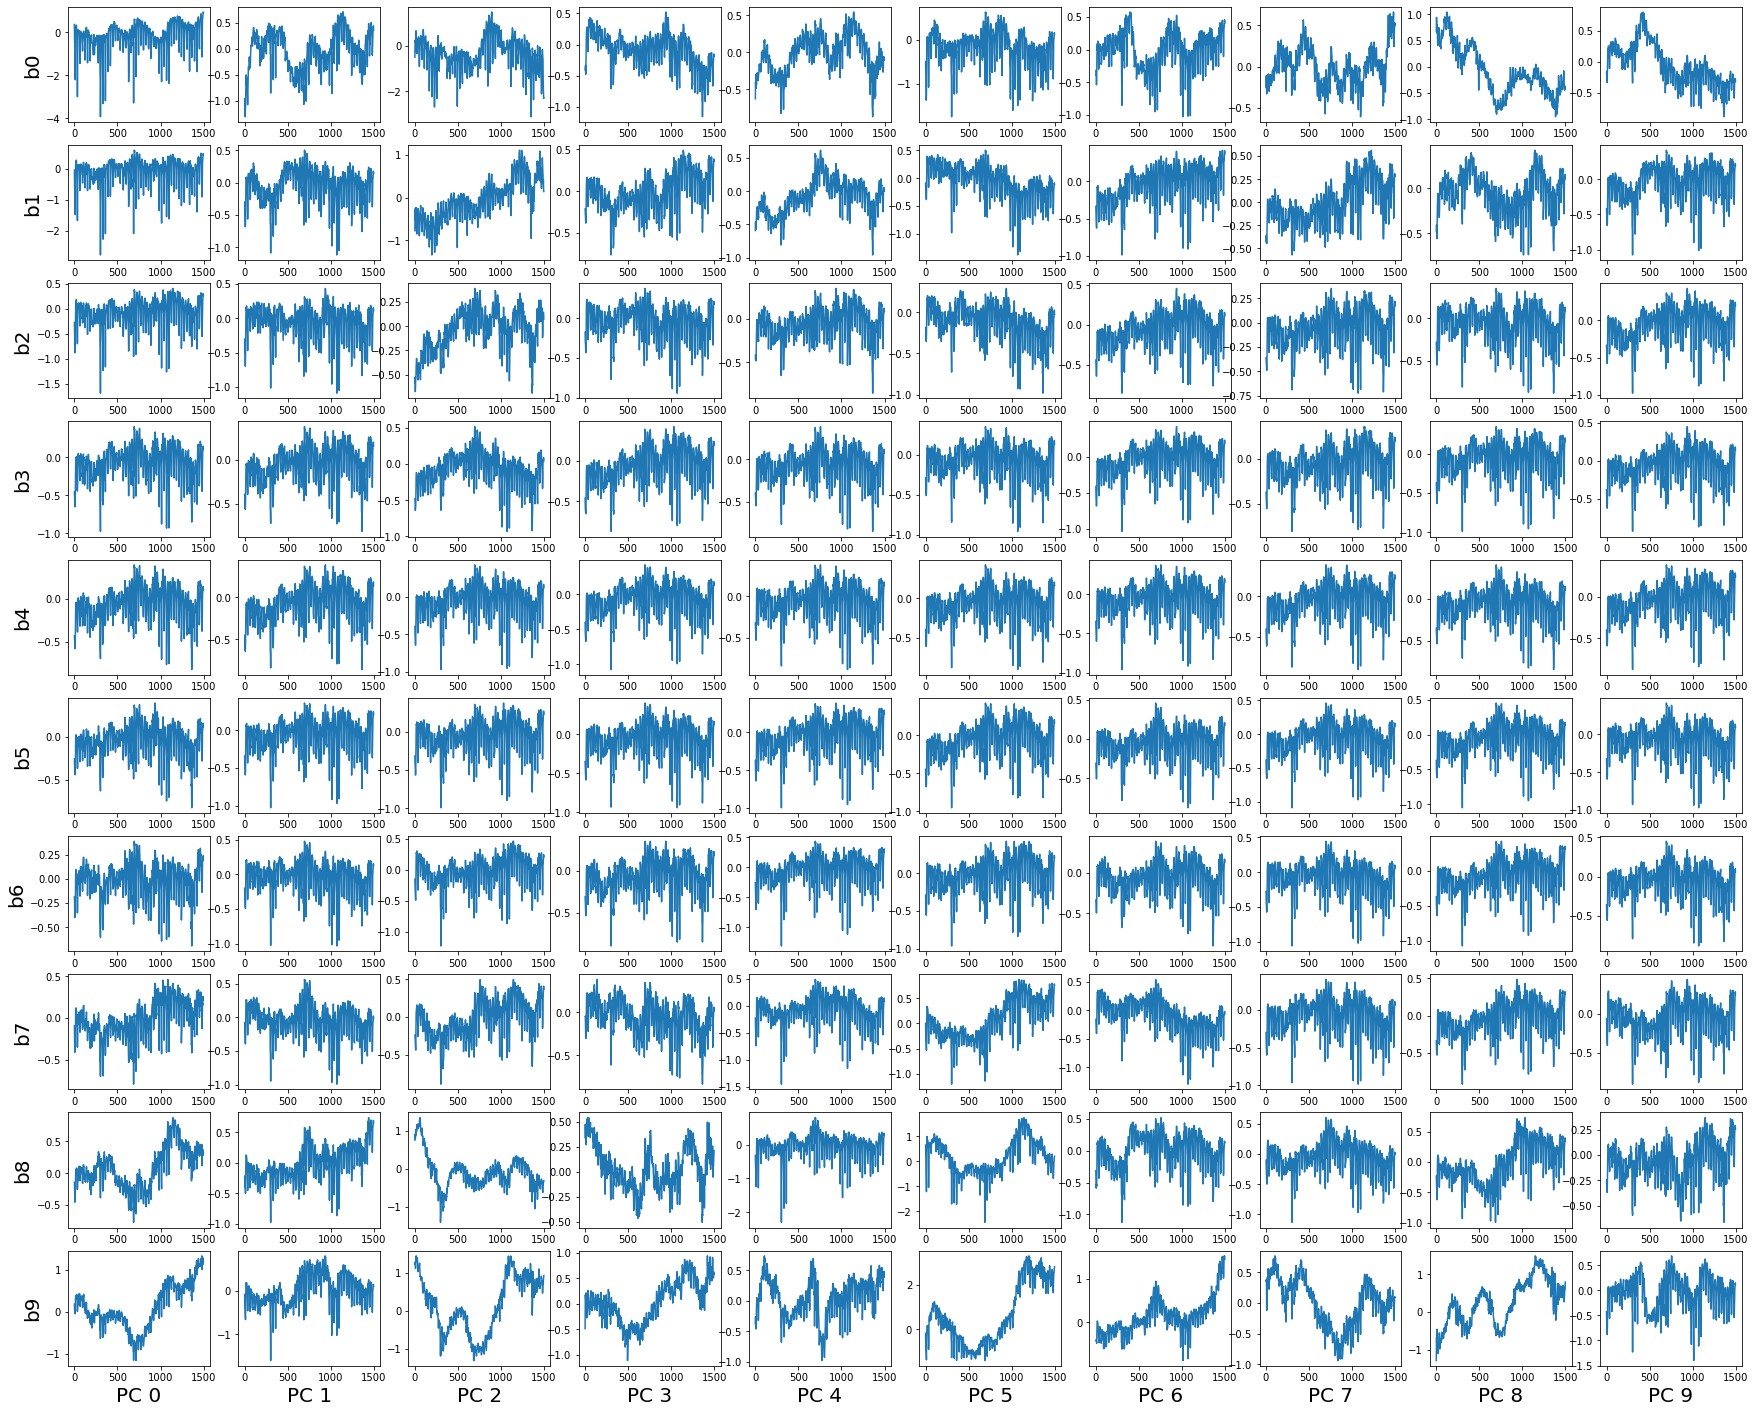

In [459]:
pca_comps = 10
fs = 20
fig, ax = plt.subplots(bins, pca_comps, figsize=(30,25))
for i in range(pca_comps):
    ax[9,i].set_xlabel(f'PC {i}',fontsize=fs)
    for bin in range(bins):
        ax[bin,0].set_ylabel(f'b{bin}',fontsize=fs)
        interps = interpols[i]
        ax[bin,i].plot(interps[bin,0,:,0], interps[bin,0,:,1])
            
            
        
#plt.savefig('../img/pca4drecons')

In [ ]:
## bin 10 of PC 3 looks interesting...

In [460]:
pc = 5

r1,r2 = np.min(pca3d[:,pc]), np.max(pca3d[:,pc])
    
bins1 = np.arange(r1,r2, step=(r2-r1)/10)
    
bin_i = np.digitize(pca3d[:,pc],bins=bins1) # which light curve belongs to which bin? 

In [463]:
lcs.valid_files_df[bin_i == 10]

,g
152735.09+435044.9,../../datasets/ZTF_g/g/152735.09+435044.9_DR_g...


In [464]:
pc3bin10 = np.where(bin_i == 10)[0]
print(list(pc3bin10))

[557]


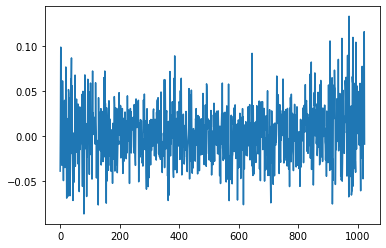

In [453]:
# find others in the vicinity? 

plt.plot(pca.components_[pc,:])

In [ ]:
## MLP 